In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import random

In [2]:
nfl_pbp = pd.read_csv('./data/2023_NFL_PbP_Logs.csv',
                      usecols = [
                          'QUARTER',
                          'DOWN',
                          'TO_GO',
                          'OFFENSIVE_TEAM_VENUE',
                          'SCORE_DIFFERENTIAL',
                          'PLAY_TYPE',
                          'YARDS_GAINED'
                      ])

nfl_pbp = nfl_pbp[(nfl_pbp['DOWN'] == 4) & \
                  (nfl_pbp['PLAY_TYPE'].isin(['Pass', 'Run']))]

nfl_pbp['YARDS_GAINED'] = nfl_pbp['YARDS_GAINED'].fillna(0)

nfl_pbp.loc[nfl_pbp['OFFENSIVE_TEAM_VENUE'] == 'Road', 'SCORE_DIFFERENTIAL'] *= -1

OFFENSIVE_TEAM_VENUE_mapping = {'Road': 0, 'Home': 1}
nfl_pbp['OFFENSIVE_TEAM_VENUE'] = nfl_pbp['OFFENSIVE_TEAM_VENUE'].map(OFFENSIVE_TEAM_VENUE_mapping)

PLAY_TYPE_mapping = {'Run': 0, 'Pass': 1}
nfl_pbp['PLAY_TYPE'] = nfl_pbp['PLAY_TYPE'].map(PLAY_TYPE_mapping)

nfl_pbp['CONVERT'] = np.where(nfl_pbp['YARDS_GAINED'] < nfl_pbp['TO_GO'], 0, 1 )

print(nfl_pbp.info())

pd.set_option('display.max_columns', None)
print(nfl_pbp.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 883 entries, 16 to 52381
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   QUARTER               883 non-null    int64  
 1   DOWN                  883 non-null    float64
 2   TO_GO                 883 non-null    float64
 3   OFFENSIVE_TEAM_VENUE  881 non-null    float64
 4   SCORE_DIFFERENTIAL    883 non-null    int64  
 5   PLAY_TYPE             883 non-null    int64  
 6   YARDS_GAINED          883 non-null    float64
 7   CONVERT               883 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 62.1 KB
None
     QUARTER  DOWN  TO_GO  OFFENSIVE_TEAM_VENUE  SCORE_DIFFERENTIAL  \
16         1   4.0    2.0                   0.0                   0   
85         2   4.0   10.0                   0.0                  -7   
162        4   4.0    2.0                   0.0                   1   
168        4   4.0   25.0                   1.0 

In [3]:
convert_counts = nfl_pbp['CONVERT'].value_counts()
print(convert_counts)

CONVERT
1    462
0    421
Name: count, dtype: int64


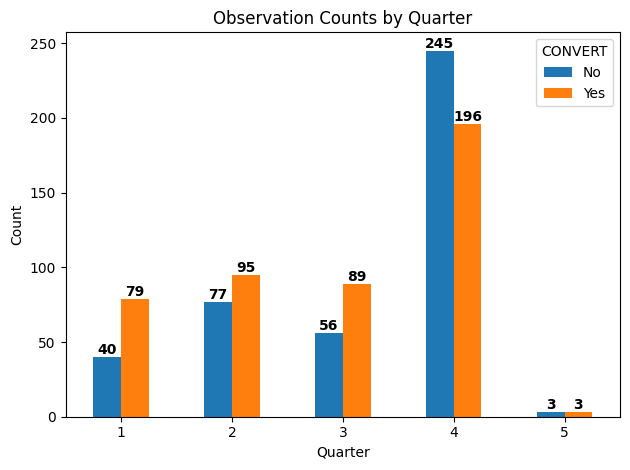

In [4]:
grouped_data = (nfl_pbp.groupby(['QUARTER', 'CONVERT']).size().unstack(fill_value=0))
grouped_data.plot(kind='bar')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(),
             str(p.get_height()), ha='center', va='bottom',
             fontweight='bold', color='black')
    
plt.title('Observation Counts by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.legend(title = 'CONVERT', labels = ['No', 'Yes'])
plt.tight_layout()
plt.show()


CONVERT
0    5.947743
1    2.560606
Name: TO_GO, dtype: float64
CONVERT
0    4.0
1    1.0
Name: TO_GO, dtype: float64


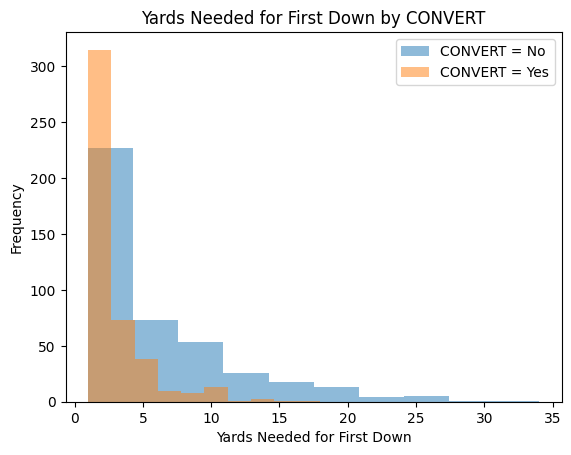

In [5]:
mean_to_go_by_convert = nfl_pbp.groupby('CONVERT')['TO_GO'].mean()
print(mean_to_go_by_convert)
median_to_go_by_convert = nfl_pbp.groupby('CONVERT')['TO_GO'].median()
print(median_to_go_by_convert)

convert_0_data = nfl_pbp[nfl_pbp['CONVERT'] == 0]['TO_GO']
convert_1_data = nfl_pbp[nfl_pbp['CONVERT'] == 1]['TO_GO']

plt.subplot()
plt.hist(convert_0_data, alpha = 0.5, label = 'CONVERT = No')
plt.hist(convert_1_data, alpha = 0.5, label = 'CONVERT = Yes')
plt.title('Yards Needed for First Down by CONVERT')
plt.xlabel('Yards Needed for First Down')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [6]:
mean_score_differential_by_convert = nfl_pbp.groupby('CONVERT')['SCORE_DIFFERENTIAL'].mean()
print(mean_score_differential_by_convert)
median_score_differential_by_convert = nfl_pbp.groupby('CONVERT')['SCORE_DIFFERENTIAL'].median()
print(median_score_differential_by_convert)

score_differential_counts = (nfl_pbp['SCORE_DIFFERENTIAL'] \
                   .agg({'negative': lambda x: (x < 0).sum(), \
                         'positive': lambda x: (x > 0).sum(), \
                         'zero': lambda x: (x == 0).sum()}))
print(score_differential_counts)

CONVERT
0   -7.125891
1   -3.688312
Name: SCORE_DIFFERENTIAL, dtype: float64
CONVERT
0   -7.0
1   -4.0
Name: SCORE_DIFFERENTIAL, dtype: float64
negative    577
positive    212
zero         94
Name: SCORE_DIFFERENTIAL, dtype: int64


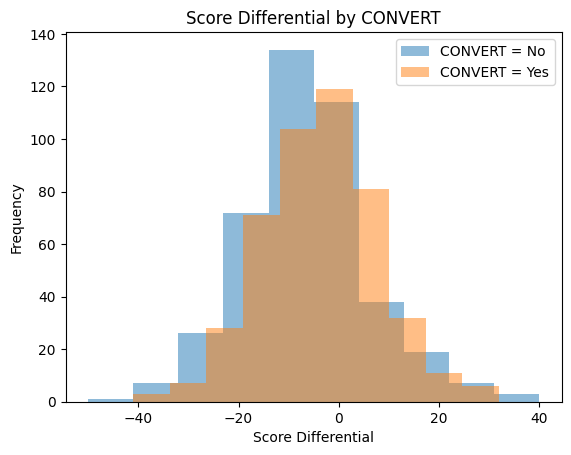

In [7]:
convert_0_data = nfl_pbp[nfl_pbp['CONVERT'] == 0]['SCORE_DIFFERENTIAL']
convert_1_data = nfl_pbp[nfl_pbp['CONVERT'] == 1]['SCORE_DIFFERENTIAL']

plt.subplot()
plt.hist(convert_0_data, alpha = 0.5, label = 'CONVERT = No')
plt.hist(convert_1_data, alpha = 0.5, label = 'CONVERT = Yes')
plt.title('Score Differential by CONVERT')
plt.xlabel('Score Differential')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [8]:
home_road_counts = nfl_pbp.groupby(['OFFENSIVE_TEAM_VENUE', 'CONVERT']).size().reset_index(name='counts')
print(home_road_counts)

   OFFENSIVE_TEAM_VENUE  CONVERT  counts
0                   0.0        0     240
1                   0.0        1     233
2                   1.0        0     181
3                   1.0        1     227


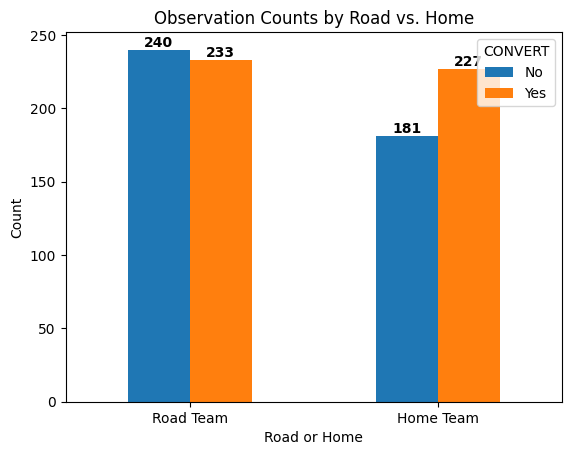

In [9]:
grouped_data = (nfl_pbp.groupby(['OFFENSIVE_TEAM_VENUE', 'CONVERT']).size().unstack(fill_value=0))
grouped_data.plot(kind='bar')

for p in plt.gca().patches:
    plt.gca().annotate(str(p.get_height()),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'bottom',
                       fontweight = 'bold', color = 'black')

plt.title('Observation Counts by Road vs. Home')
plt.xlabel('Road or Home')
plt.ylabel('Count')
plt.xticks([0, 1], labels = ['Road Team', 'Home Team'],
           rotation = 0)
plt.legend(title = 'CONVERT', labels = ['No', 'Yes'],
           loc = 'upper right')
plt.show()  

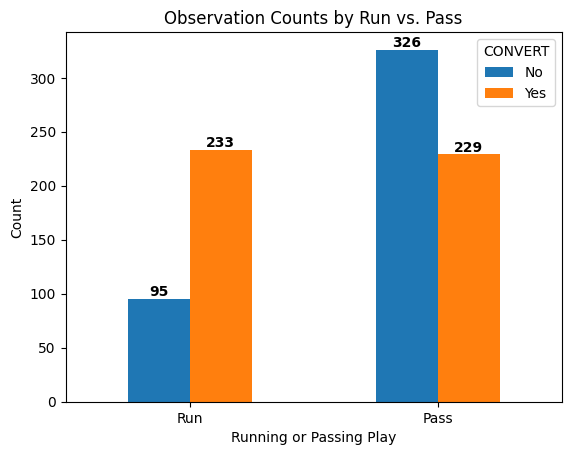

In [10]:
grouped_data = (nfl_pbp.groupby(['PLAY_TYPE', 'CONVERT']).size().unstack(fill_value = 0))
# plot grouped bar chart
grouped_data.plot(kind = 'bar')
for p in plt.gca().patches:
    plt.gca().annotate(str(p.get_height()),
                       (p.get_x() + p.get_width() /
                        2., p.get_height()),
                       ha = 'center', va = 'bottom',
                       fontweight = 'bold', color = 'black')
plt.title('Observation Counts by Run vs. Pass')
plt.xlabel('Running or Passing Play')
plt.ylabel('Count')
plt.xticks([0, 1], labels = ['Run', 'Pass'],
           rotation = 0)
#ax.set_xticklabels(['Run', 'Pass'])
plt.legend(title = 'CONVERT', labels = ['No', 'Yes'])
plt.show()

In [11]:
mean_to_go_by_play_type = nfl_pbp.groupby('PLAY_TYPE')['TO_GO'].mean()
print(mean_to_go_by_play_type)
median_to_go_by_play_type = nfl_pbp.groupby('PLAY_TYPE')['TO_GO'].median()
print(median_to_go_by_play_type)

PLAY_TYPE
0    1.948171
1    5.491892
Name: TO_GO, dtype: float64
PLAY_TYPE
0    1.0
1    4.0
Name: TO_GO, dtype: float64


In [12]:
X = nfl_pbp[['QUARTER', 'TO_GO', 'OFFENSIVE_TEAM_VENUE', 'SCORE_DIFFERENTIAL', 'PLAY_TYPE']]
y = nfl_pbp['CONVERT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(618, 5)
(265, 5)
(618,)
(265,)


In [13]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [14]:
clf_accuracy = metrics.accuracy_score(y_test, y_pred) * 100

print(f'Accuracy: {round(clf_accuracy, 0)}%')

results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})

print(results.head(10))
count = len(results[(results['actual'] == 0) & (results['predicted'] == 0)])
print(count)

count = len(results[(results['actual'] == 1) & (results['predicted'] == 1)])
print(count)

count = len(results[(results['actual'] == 0) & (results['predicted'] == 1)])
print(count)

count = len(results[(results['actual'] == 1) & (results['predicted'] == 0)])
print(count)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

accuracy_rate_0 = 71 / (71 + 67) * 100
print(f'Accuracy: {round(accuracy_rate_0, 0)}%')

accuracy_rate_1 = 91 / (91 + 36) * 100
print(f'Accuracy: {round(accuracy_rate_1, 0)}%')

Accuracy: 61.0%
       actual  predicted
36002       0          0
41227       1          1
44051       1          1
21777       0          1
34977       1          1
9986        0          1
37230       0          0
3646        1          1
21528       0          1
23942       1          1
71
91
67
36
[[71 67]
 [36 91]]
Accuracy: 51.0%
Accuracy: 72.0%


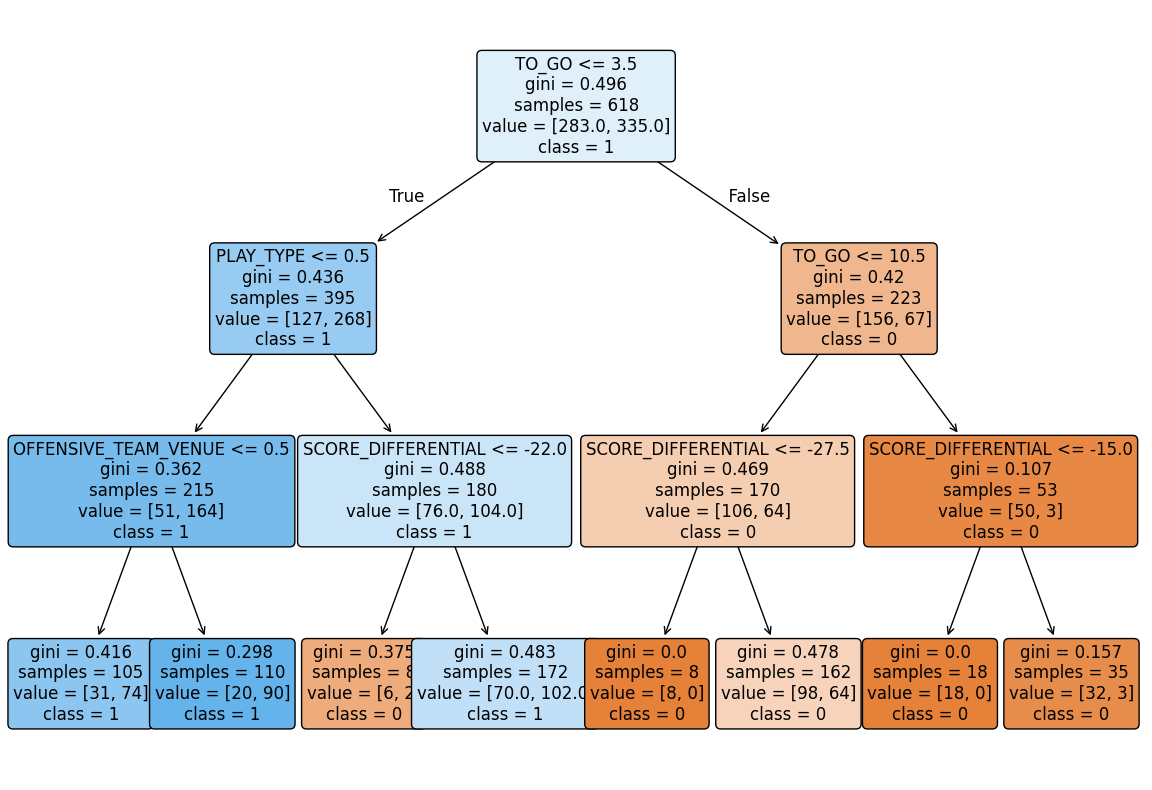

In [15]:
plt.figure(figsize = (12, 8))
tree.plot_tree(clf, feature_names = ['QUARTER',
                                     'TO_GO',
                                     'OFFENSIVE_TEAM_VENUE',
                                     'SCORE_DIFFERENTIAL',
                                     'PLAY_TYPE'],
               class_names = ['0', '1'],
               filled = True,
               rounded = True,
               fontsize = 12)
plt.tight_layout()
plt.show()


In [16]:
train_data = pd.concat([X_train, y_train], axis=1)
counts = train_data.groupby(['PLAY_TYPE', 'CONVERT']).size()
print(counts)

to_go_less_than_3_5 = train_data[train_data['TO_GO'] <= 3.5]
to_go_greater_than_3_5 = train_data[train_data['TO_GO'] > 3.5]
counts_less_than_3_5 = (to_go_less_than_3_5.groupby('CONVERT').size())
print('Counts for TO_GO <= 3.5:')
print(counts_less_than_3_5)

counts_greater_than_3_5 = (to_go_greater_than_3_5.groupby('CONVERT').size())
print('Counts for TO_GO > 3.5:')
print(counts_greater_than_3_5)

PLAY_TYPE  CONVERT
0          0           64
           1          175
1          0          219
           1          160
dtype: int64
Counts for TO_GO <= 3.5:
CONVERT
0    127
1    268
dtype: int64
Counts for TO_GO > 3.5:
CONVERT
0    156
1     67
dtype: int64


In [17]:
rf = RandomForestClassifier(n_estimators = 50, criterion = 'gini', max_depth = 3, random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test, y_pred) * 100
print(f'Accuracy: {round(rf_accuracy, 0)}%')

Accuracy: 62.0%


In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
accuracy_rate_0 = 70 / (70 + 68) * 100
print(f'Accuracy: {round(accuracy_rate_0, 0)}%')
accuracy_rate_1 = 95 / (95 + 32) * 100
print(f'Accuracy: {round(accuracy_rate_1, 0)}%')

[[68 70]
 [32 95]]
Accuracy: 51.0%
Accuracy: 75.0%


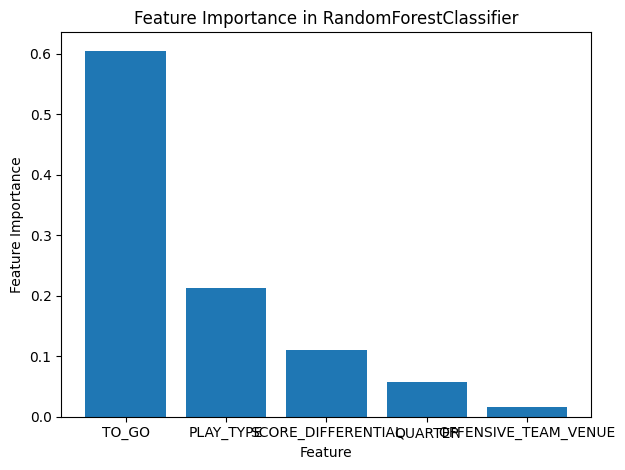

In [19]:
importances = rf.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]

plt.figure()
plt.bar(sorted_features, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in RandomForestClassifier')
plt.tight_layout()
plt.show()

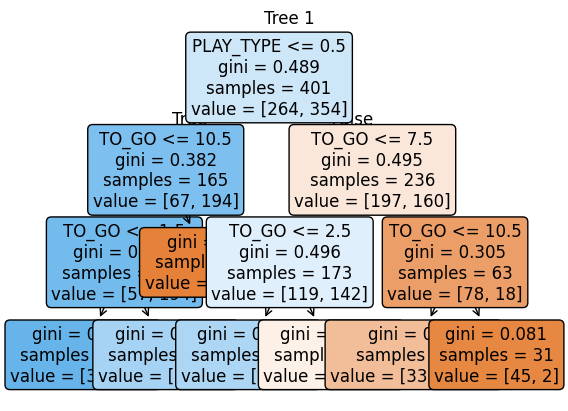

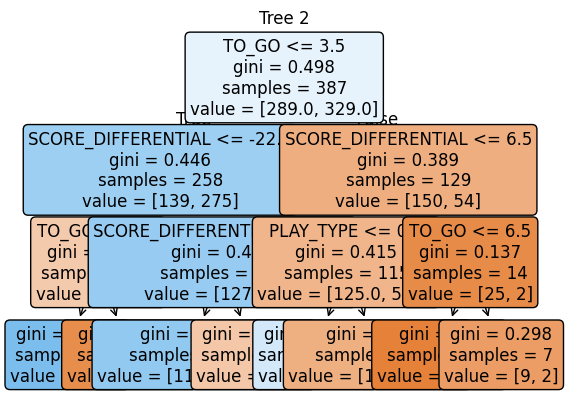

In [20]:
random_trees = random.sample(rf.estimators_, 2)
for i, tree in enumerate(random_trees):
    plt.figure()
    plot_tree(tree, feature_names = X_train.columns,
              filled = True,
              rounded = True,
              fontsize = 12)
    plt.title(f'Tree {i+1}')
    plt.show()